# Autoencoder

In [1]:
import os
import numpy as np

from utils.loaders import load_mnist
from models.AE import Autoencoder

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

2022-12-27 21:43:25.967067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set parameters

In [4]:
# run params
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

MODE =  'build' #'load' #

## Load the data

In [5]:
(x_train, y_train), (x_test, y_test) = load_mnist()

## Define the structure of the neural network

In [5]:
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

2022-12-26 21:28:08.265645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
AE.encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 64)          0     

In [7]:
AE.decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_0 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_1 (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                   

## Train the autoencoder

In [8]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0

In [9]:
AE.compile(LEARNING_RATE)

/Users/benjamincross/miniconda3/envs/GDL/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
AE.train(     
    x_train[:1000]
    , batch_size = BATCH_SIZE
    , epochs = 200
    , run_folder = RUN_FOLDER
    , initial_epoch = INITIAL_EPOCH
)

Epoch 1/200
31/32 [============================>.] - ETA: 0s - loss: 0.1751
Epoch 1: saving model to run/vae/0001_digits/weights/weights.h5
32/32 [==============================] - 4s 88ms/step - loss: 0.1745 - lr: 5.0000e-04
Epoch 2/200
31/32 [============================>.] - ETA: 0s - loss: 0.0791
Epoch 2: saving model to run/vae/0001_digits/weights/weights.h5
32/32 [==============================] - 3s 87ms/step - loss: 0.0791 - lr: 5.0000e-04
Epoch 3/200
31/32 [============================>.] - ETA: 0s - loss: 0.0673
Epoch 3: saving model to run/vae/0001_digits/weights/weights.h5
32/32 [==============================] - 3s 88ms/step - loss: 0.0673 - lr: 5.0000e-04
Epoch 4/200
31/32 [============================>.] - ETA: 0s - loss: 0.0643
Epoch 4: saving model to run/vae/0001_digits/weights/weights.h5
32/32 [==============================] - 3s 91ms/step - loss: 0.0643 - lr: 5.0000e-04
Epoch 5/200
31/32 [============================>.] - ETA: 0s - loss: 0.0604
Epoch 5: saving mode

## Pytorch Implementation

In [10]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(-1, *self.shape)

class PytorchAutoencoder(nn.Module):
    def __init__(
        self,
        img_size,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        encoder_conv_padding,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        decoder_conv_t_padding,
        z_dim,
        use_batch_norm = False,
        use_dropout = False,
    ):
        super().__init__()
        self.img_size = img_size
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.encoder_conv_padding = encoder_conv_padding
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.decoder_conv_t_padding = decoder_conv_t_padding
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)
        
        self._decoder_size = None

        self._build_encoder()
        self._build_decoder()
        self._initialize_weights()

    def _build_encoder(self):
        ### THE ENCODER
        self.encoder = nn.Sequential()
        in_channels = self.img_size[0]
        sample = torch.zeros(*self.img_size).unsqueeze(0)
        for i in range(self.n_layers_encoder):
            out_channels = self.encoder_conv_filters[i]
            kernel = self.encoder_conv_kernel_size[i]
            strides = self.encoder_conv_strides[i]
            padding = self.encoder_conv_padding[i]
            conv_layer = nn.Conv2d(
                in_channels,
                out_channels,
                kernel,
                strides,
                padding,
            )
            self.encoder.add_module("encoder_conv_" + str(i), conv_layer)
            
            if self.use_batch_norm:
                bn = nn.BatchNorm2d(self.encoder_conv_filters[i])
                self.encoder.add_module("ebn_" + str(i), bn)
                
            self.encoder.add_module("elrelu_" + str(i), nn.LeakyReLU(0.3))
        
            if self.use_dropout:
                dl = nn.Dropout2d(0.25)
                self.encoder.add_module("edrop2d_" + str(i), dl)
                
            in_channels = self.encoder_conv_filters[i]
            sample = conv_layer(sample)
        
        # get dimensions
        self._decoder_size = sample.shape[1:]
        nd = np.prod(self._decoder_size)
        
        self.encoder.add_module("eflatten", nn.Flatten())
        self.encoder.add_module("encoder_output", nn.Linear(nd, self.z_dim))

    def _build_decoder(self):
        ### THE DECODER
        nd = np.prod(self._decoder_size)
        self.decoder = nn.Sequential()
        self.decoder.add_module("decoder_expand", nn.Linear(self.z_dim, nd))
        self.decoder.add_module("decoder_reshape", View(self._decoder_size))
        in_channels = self._decoder_size[0]
        for i in range(self.n_layers_decoder):
            out_channels = self.decoder_conv_t_filters[i]
            kernel = self.decoder_conv_t_kernel_size[i]
            strides = self.decoder_conv_t_strides[i]
            padding = self.decoder_conv_t_padding[i]
            conv_t_layer = nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel,
                strides,
                padding,
            )
            self.decoder.add_module("decoder_conv_t_" + str(i), conv_t_layer)
        
            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    self.decoder.add_module("decoder_bn_" + str(i), nn.BatchNorm2d(out_channels))
                    
                self.decoder.add_module("decoder_lr_" + str(i), nn.LeakyReLU(0.3))
                
                if self.use_dropout:
                    self.decoder.add_module("decoder_drop_" + str(i), nn.Dropout2d(0.25))
            else:
                self.decoder.add_module("decoder_lr_" + str(i), nn.LeakyReLU(0.3))
            in_channels = out_channels
            
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out
    
    def _initialize_weights(self):
        with torch.no_grad():
            self.apply(self.init_weights)
                
    @staticmethod
    def init_weights(layer):
        if type(layer) in [nn.BatchNorm1d, nn.BatchNorm2d]:
            layer.weight.data.fill_(1.0)
            layer.bias.data.fill_(0.0)
        else:
            if hasattr(layer, "weight"):
                torch.nn.init.xavier_uniform_(layer.weight)

            if hasattr(layer, "bias"):
                layer.bias.data.fill_(0.0)
                
    def fit(self, X, learning_rate=0.0005, batch_size=32, epochs=10, shuffle=True):
        optimizer = torch.optim.Adam(lr=learning_rate, params=self.parameters())
        dataset = TensorDataset(X)
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
        )

        loss_fn = nn.MSELoss(reduction="sum")
        for epoch in range(1, epochs + 1):
            n, total_loss = 0, 0.0
            for obs, in train_loader:
                outputs = self(obs)
                loss = loss_fn(outputs, obs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                n += outputs.shape[0]
                total_loss += float(loss.item())
                
            avg_loss = 1.0 * total_loss / n
            print(f"Epoch {epoch} Loss: {avg_loss:.6f}")
        
        return self

In [7]:
x_train_pt = (
    torch
    .from_numpy(x_train)
    .to(torch.float32)
    .movedim(3, 1)
)
x_test_pt = (
    torch
    .from_numpy(x_test)
    .to(torch.float32)
    .movedim(3, 1)
)

In [11]:
pytorch_model = PytorchAutoencoder(
    img_size=list(x_train_pt[0].shape),
    encoder_conv_filters=[32, 64, 64, 64],
    encoder_conv_kernel_size=[3, 2, 2, 3],
    encoder_conv_strides=[1, 2, 2, 1],
    encoder_conv_padding=[1, 0, 0, 1],
    decoder_conv_t_filters=[64, 64, 32, 1],
    decoder_conv_t_kernel_size=[3, 2, 2, 3],
    decoder_conv_t_strides=[1, 2, 2, 1],
    decoder_conv_t_padding=[1, 0, 0, 1],
    z_dim=2,
    use_batch_norm=True,
    use_dropout=True,
)

In [14]:
pytorch_model.fit(
    x_train_pt[:5000],
    epochs=50,
)

Epoch 1 Loss: 45.634147
Epoch 2 Loss: 44.607338
Epoch 3 Loss: 43.945875
Epoch 4 Loss: 43.486574
Epoch 5 Loss: 43.217710
Epoch 6 Loss: 42.806450
Epoch 7 Loss: 42.503122
Epoch 8 Loss: 42.285221
Epoch 9 Loss: 41.902910
Epoch 10 Loss: 41.701947
Epoch 11 Loss: 41.590412
Epoch 12 Loss: 41.447162
Epoch 13 Loss: 41.206186
Epoch 14 Loss: 41.231350
Epoch 15 Loss: 41.111880
Epoch 16 Loss: 40.886067
Epoch 17 Loss: 40.736650
Epoch 18 Loss: 40.630234
Epoch 19 Loss: 40.594311
Epoch 20 Loss: 40.384555
Epoch 21 Loss: 40.394290
Epoch 22 Loss: 40.273253
Epoch 23 Loss: 40.318822
Epoch 24 Loss: 40.126144
Epoch 25 Loss: 40.033668
Epoch 26 Loss: 40.009661
Epoch 27 Loss: 39.973195
Epoch 28 Loss: 39.827679
Epoch 29 Loss: 39.863425
Epoch 30 Loss: 39.806161
Epoch 31 Loss: 39.729699
Epoch 32 Loss: 39.601258
Epoch 33 Loss: 39.460652
Epoch 34 Loss: 39.599465
Epoch 35 Loss: 39.416585
Epoch 36 Loss: 39.439682
Epoch 37 Loss: 39.396855
Epoch 38 Loss: 39.268268
Epoch 39 Loss: 39.300706
Epoch 40 Loss: 39.238327
Epoch 41 

PytorchAutoencoder(
  (encoder): Sequential(
    (encoder_conv_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ebn_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elrelu_0): LeakyReLU(negative_slope=0.3)
    (edrop2d_0): Dropout2d(p=0.25, inplace=False)
    (encoder_conv_1): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (ebn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elrelu_1): LeakyReLU(negative_slope=0.3)
    (edrop2d_1): Dropout2d(p=0.25, inplace=False)
    (encoder_conv_2): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (ebn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elrelu_2): LeakyReLU(negative_slope=0.3)
    (edrop2d_2): Dropout2d(p=0.25, inplace=False)
    (encoder_conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ebn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
pytorch_model.eval()
pts = pytorch_model.encoder(x_train_pt[:10000]).detach().numpy()

In [17]:
pts.shape

(10000, 2)

In [18]:
pts[:10]

array([[-2.8141673 ,  0.4311796 ],
       [-8.817258  , -2.7788289 ],
       [ 2.644913  , -4.3131614 ],
       [-0.12451342,  7.7473154 ],
       [ 4.0677547 , -0.09553777],
       [-2.1877038 ,  2.345653  ],
       [ 6.1030116 ,  4.168648  ],
       [-4.213995  ,  0.87252164],
       [ 7.281311  ,  4.984095  ],
       [ 0.6262615 ,  1.0547525 ]], dtype=float32)

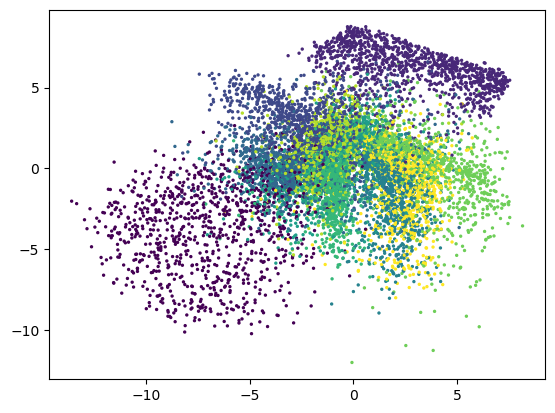

In [19]:
plt.scatter(pts[:, 0], pts[:, 1], s=2, c=y_train[:10000])